## Task 1 - Optimal Transport in 1D

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from cycler import cycler
from matplotlib import rcParams
from matplotlib.cm import get_cmap
from math import sqrt

In [2]:
mu_1, sigma_1 = 25, 5 # mean and standard deviation
mu_2, sigma_2 = 100, 10 # mean and standard deviation
num_samples = 10000 # num samples

# Distribution 1
x_1 = np.random.normal(mu_1, sigma_1, num_samples)
y_1 = stats.norm.pdf(x_1, mu_1, sigma_1)
x_1, y_1 = zip(*sorted(zip(x_1, y_1)))

# Distribution 2
x_2 = np.random.normal(mu_2, sigma_2, num_samples)
y_2 = stats.norm.pdf(x_2, mu_2, sigma_2)
x_2, y_2 = zip(*sorted(zip(x_2, y_2)))

# Stack into points
p_1 = np.vstack((x_1,y_1))
p_2 = np.vstack((x_2,y_2))


### 2-Wasserstein distance calculation (closed-form vs. sampled)

In [3]:
# Closed form 2-Wasserstein:
closed_Wasserstein = abs(mu_1-mu_2) +  (sigma_1 + sigma_2 - 2 * sqrt(sigma_2*sigma_1))

# Sampled 2-Wasserstein
difference = p_1 - p_2
sampled_Wasserstein = np.average(np.linalg.norm(difference, axis=0))

print("Closed form solution:    " + str(closed_Wasserstein))
print("Sampled solution:        " + str(sampled_Wasserstein))

Closed form solution:    75.85786437626905
Sampled solution:        74.83127623119458


### Plot Distributions

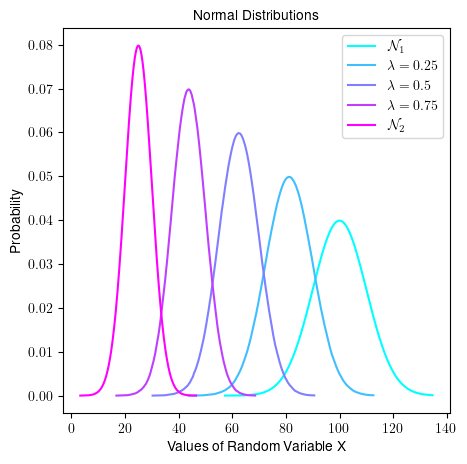

In [30]:
plt.figure(figsize=(5,5))

# Lambdas
lambdas = [0, 0.25, 0.5, 0.75, 1.0]

cmap = get_cmap('cool')
colors = []

# Allow latex
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

# Generate and plot interpolated samples alongside distributions 1 and 2
for lamb in lambdas:
    z = lamb * p_1 + (1-lamb) * p_2
    colors.append(cmap(lamb))
    if(lamb == 0.0):
        plt.plot(z[0,:], z[1,:], label= "$\mathcal{N}_1$")
    elif(lamb == 1.0):
        plt.plot(z[0,:], z[1,:], label= "$\mathcal{N}_2$")
    else:    
        label = "$\lambda={}$".format(lamb)
        plt.plot(z[0,:], z[1,:], label= label)

# Set colormap
rcParams['axes.prop_cycle'] = cycler(color=colors)

plt.title('Normal Distributions', fontsize='10')
plt.xlabel('Values of Random Variable X', fontsize='10')
plt.ylabel('Probability', fontsize='10')
plt.legend()
plt.show()